In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/AI/Image_Caption")
!ls

checkpoints  Flickr8k  Untitled0.ipynb	Untitled1.ipynb


In [1]:
# Import libraries

import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [2]:
base_dir = '/flickr8k'

In [3]:
# Read caption

img_id_caption = pd.read_csv("flickr8k/captions.txt", sep=',')
print(len(img_id_caption))
display(img_id_caption.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [4]:
from textwrap import wrap
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [6]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

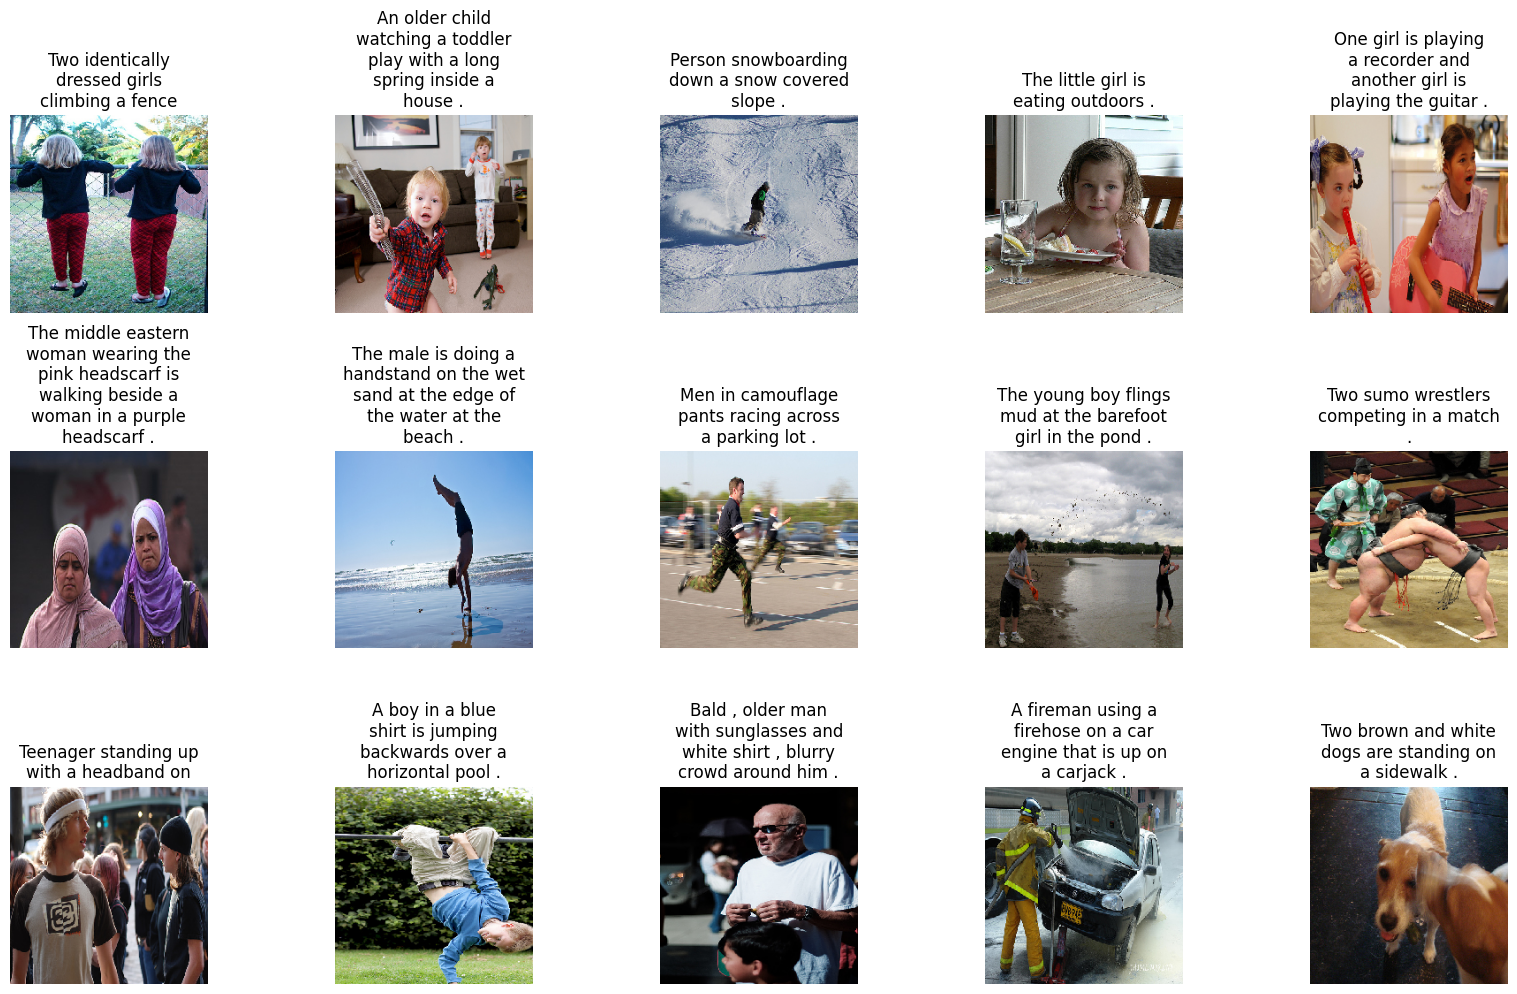

In [9]:
# Display 5 images
display_images(img_id_caption.sample(20))

In [10]:
# Clean data
import re
def process(data):
    clean_data=[]
    for word in data.split():
        if len(word)>1:
            word=word.lower()
            word=re.sub('[^A-za-z]','',word)
            clean_data.append(word)

    return clean_data

In [11]:
img_id_caption['cleaned_caption'] = img_id_caption['caption'].apply(lambda x: 'start '+' '.join(process(x))+ ' end')

In [15]:
img_id_caption.sample(5)

,image,caption,cleaned_caption
4859,2089555297_95cf001fa7.jpg,"The man wearing a backpack and a hat , stands ...",start the man wearing backpack and hat stands ...
18106,2993049054_611f900644.jpg,A person wearing a mask .,start person wearing mask end
8847,241345864_138471c9ea.jpg,cheerleaders taking a break,start cheerleaders taking break end
25083,3315726723_64c9b0a945.jpg,Wrestlers about to start a match .,start wrestlers about to start match end
38276,532457586_bddfc5251d.jpg,A shirtless man with a dog next to him talking...,start shirtless man with dog next to him talki...


In [16]:
img_id_caption.shape

(40455, 3)

In [17]:
all_captions = img_id_caption['cleaned_caption'].to_list()
len(all_captions)

40455

In [18]:
img_id_caption.drop(columns=['caption'],inplace=True)

# Convert DataFrame to dictionary with lists for duplicate keys
caption_dict = {k: v.tolist() for k, v in img_id_caption.groupby('image')['cleaned_caption']}

caption_dict['1000268201_693b08cb0e.jpg']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [19]:
image_id = list(caption_dict.keys())
len(image_id)

8091

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
voc_size = len(tokenizer.word_index)+1

In [21]:
max_caption_len = max([len(i.split()) for i in all_captions])

In [22]:
train_data = image_id[:int(len(image_id)*.90)]
val_data = image_id[int(len(image_id)*.90):]
len(train_data),len(val_data)

(7281, 810)

In [23]:
train_data[:5]

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg']

In [24]:
train_df = img_id_caption[img_id_caption['image'].isin(train_data)]
test_df = img_id_caption[img_id_caption['image'].isin(val_data)]

In [25]:
# Define encoder
model = VGG16()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

In [1]:
# Extracting image features

features = {}
for img_name in tqdm(os.listdir('./flickr8k/Images')):
    img_path = os.path.join('./flickr8k/Images',img_name)
    img = load_img(img_path,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = fe.predict(img, verbose=0)
    features[img_name] = feature

NameError: name 'tqdm' is not defined

In [ ]:
# Data generation

def data_generator(data,caption_dict,features,tokenizer,max_length,voc_size,batch_size):
    x1=[]
    x2=[]
    y=[]
#     batch_size=64
    n=0
    while(1):
        for id in data:
            n+=1
            captions = caption_dict[id]
            for caption in captions:
                #Tokenizing the caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_caption_len)[0]
                    out_seq = to_categorical([out_seq],num_classes=voc_size)[0]
                    x1.append(features[id][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                x1,x2,y = np.array(x1),np.array(x2),np.array(y)
                yield [x1,x2],y
                x1,x2,y=list(),list(),list()
                n=0

In [ ]:
generators = data_generator(train_data,caption_dict,features,tokenizer,max_caption_len,voc_size,64)

In [ ]:
# Define model: CNN + LSTM

#Model for image
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256,activation='relu')(fe1)

#model for Caption
input2 = Input(shape=(max_caption_len))
se1 = Embedding(voc_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoding_the_sequences
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)

output = Dense(voc_size,activation='softmax')(decoder2)

model=Model(inputs=[input1,input2],outputs=output)

model.compile(loss='categorical_crossentropy',optimizer='adam')

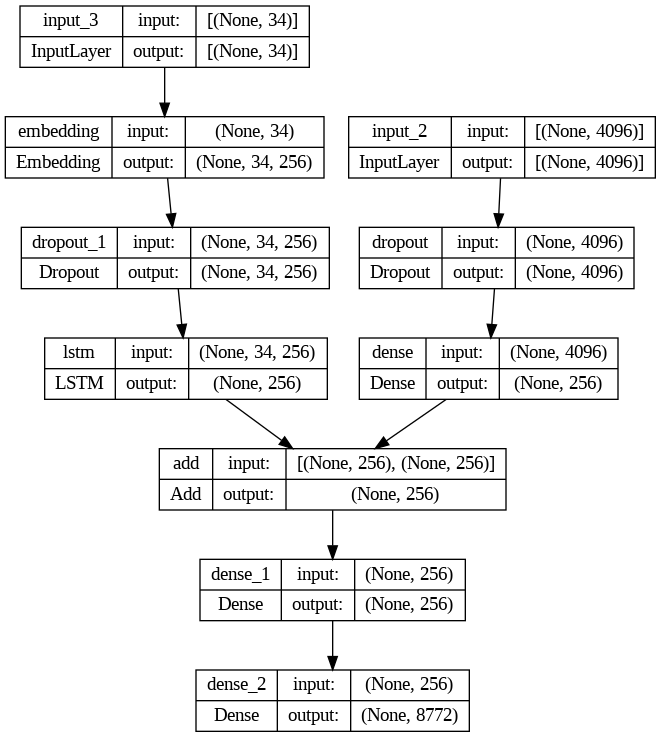

In [ ]:
#Plot_model

plot_model(model,show_shapes=True)

In [ ]:
# Train the model
epochs=20
batch_size=32
steps=len(train_data)//batch_size

for i in range(epochs):
    generators = data_generator(train_data,caption_dict,features,tokenizer,max_caption_len,voc_size,batch_size)
    model.fit(generators,epochs=1,steps_per_epoch=steps,verbose=1)


227/227 [==============================] - 70s 308ms/step - loss: 2.1675


In [ ]:
model.save("my_model.keras")

In [ ]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def prediction(model,image,tokenizer,max_caption_len):
    in_text = 'start'
    for i in range(max_caption_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_caption_len)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text+=' '+ word
        if word=='end':
            break
    return in_text

In [ ]:
base_dir = "Flickr8k/"
from PIL import Image
def enter_image_for_caption_generate(image_name):
    image_path = os.path.join(base_dir,'Images',image_name)
    image = Image.open(image_path)
    captions = caption_dict[image_name]
    print("Actual_Captions--->")
    for i in captions:
        print(i)
    print('-'*50)
    y_pred = prediction(model,features[image_name],tokenizer,max_caption_len)
    print('predicted-->')
    print(y_pred)
    print('-'*50)
    plt.imshow(image)

Actual_Captions--->
start man in wetsuit is leaving the water while waterskiing end
start man is riding board in the ocean and is being pulled from above end
start man is waterskiing on one ski end
start man riding the water on single board holding on to support with one hand end
start water glider end
--------------------------------------------------
predicted-->
start man waterskiing in the water end
--------------------------------------------------


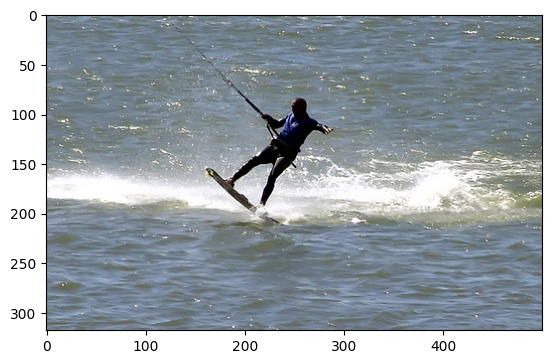

In [ ]:
enter_image_for_caption_generate('3413973568_6630e5cdac.jpg')

In [ ]:
import keras
reconstructed_model = keras.models.load_model("my_model.keras")

In [ ]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
base_dir = "Flickr8k/"
from PIL import Image
def enter_image_for_caption_generate(image_name):
    image_path = os.path.join(base_dir,'Images',image_name)
    image = Image.open(image_path)
    captions = caption_dict[image_name]
    print("Actual_Captions--->")
    for i in captions:
        print(i)
    print('-'*50)
    y_pred = prediction(reconstructed_model,features[image_name],tokenizer,max_caption_len)
    print('predicted-->')
    print(y_pred)
    print('-'*50)
    plt.imshow(image)

Actual_Captions--->
start man in wetsuit is leaving the water while waterskiing end
start man is riding board in the ocean and is being pulled from above end
start man is waterskiing on one ski end
start man riding the water on single board holding on to support with one hand end
start water glider end
--------------------------------------------------
predicted-->
start man waterskiing in the water end
--------------------------------------------------


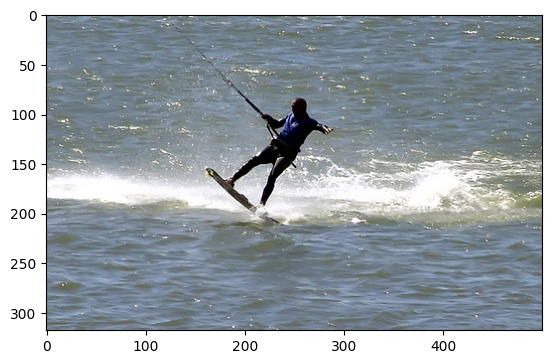

In [ ]:
enter_image_for_caption_generate('3413973568_6630e5cdac.jpg')

Actual_Captions--->
start body of water at sunset end
start sunset over lake end
start sunset sky over rippling water end
start water scene with sunset in the background end
start this is beautiful sunset on the water end
--------------------------------------------------
predicted-->
start man walking on dock with sunset in the background end
--------------------------------------------------


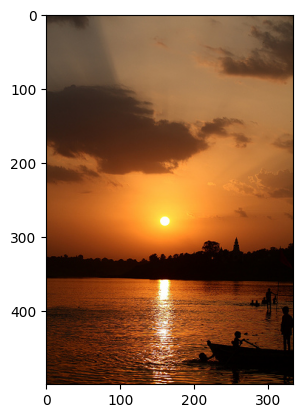

In [ ]:
enter_image_for_caption_generate('2900274587_f2cbca4c58.jpg')

In [ ]:
!pip install keras streamlit pillow numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.5 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=0ed757fc09e32e438bc5aa92f8af9db989644c55e01a4795c57edb09c9ee5100
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzloc

In [ ]:
%%writefile app.py
import streamlit as st
import keras
from PIL import Image, ImageOps
import numpy as np
st.title("Techwiz 4")
st.header("Image Captioning")
st.write("Upload your image for captioning")

uploaded_file = st.file_uploader("Choose jpg image ...", type="jpg")
if uploaded_file is not None:
  image = Image.open(uploaded_file)
  st.image(image, caption='Uploaded pic.', use_column_width=True)
  st.write("")
  st.write("Captioning...")
  #label = teachable_machine_classification(image, 'keras_model.h5') # Name of the model from Teachablemachine
  label = 0
  if label == 0:
    st.write("Is a :dog:")
  else:
    st.write("Is a :cat:")

Writing app.py
